<a href="https://colab.research.google.com/github/naufalihsan/tesseract/blob/master/Predict_Test_Complete_Ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [0]:
import pandas as pd
import numpy as np

In [0]:
from string import punctuation
from joblib import load

In [0]:
from google.colab import files

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPool1D, SpatialDropout1D
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.constraints import max_norm

In [0]:
!pip install talos

In [0]:
import talos

## Load Data

In [9]:
uploaded = files.upload()

Saving dw_customer_5000.csv to dw_customer_5000.csv


In [0]:
df = pd.read_csv('dw_customer_5000.csv', delimiter='|')

## Cleaning Data

In [0]:
df = df.dropna()
df = df.drop(columns=['ic_number'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4987 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_name   4987 non-null   object
 1   address         4987 non-null   object
 2   place_of_birth  4987 non-null   object
 3   birth_date      4987 non-null   object
 4   gender          4987 non-null   object
dtypes: object(5)
memory usage: 233.8+ KB


In [13]:
df.head()

,customer_name,address,place_of_birth,birth_date,gender
0,Nur Sholihin,Desa Mencon Rt 05 Rw 02 kecamatan Pucakwangi k...,pati,2001-06-20 00:00:00,M
1,operius waruwu,JL.JATI GG KELUARGA KOMPLEK ZIPUR,SIHAREO III,1991-08-02 00:00:00,M
2,Fika Ahsan Nugroho,"Dsn.Blaring , 004/002 , Ds.Panggungsari , Dure...",Tulungagung,1997-10-29 00:00:00,M
3,ikhsan fuzan nasrullah,Jln Moch Ramdhan no 28 kec Ciparay,Bandung,1994-07-25 00:00:00,M
4,sarbini,"desa pulau ku,u",tabalong,1992-12-30 00:00:00,M


In [0]:
name = df.customer_name

In [0]:
def clean_name(name):
  return name.lower()

In [0]:
name = name.apply(clean_name)

In [0]:
nf = { 'entity': name, 'category': 'nama' } 
df1 = pd.DataFrame(nf) 

In [0]:
rnf = pd.DataFrame({ 'entity': ['annisa febriyanti','vivin putri'], 'category': ['nama','nama'] } ) 
df1 = df1.append(rnf,ignore_index=True)

In [0]:
address = df.address

In [0]:
import re

def clean_address(addr):
  return re.sub('[^A-Za-z]+', ' ', addr).lower()

In [0]:
address = address.apply(clean_address)

In [0]:
af = { 'entity': address, 'category': 'alamat' } 
df2 = pd.DataFrame(af) 

In [0]:
birthday = df.place_of_birth + ' ' + df.birth_date

In [0]:
def clean_birthday(birth):
  ttl = birth.strip().split(" ")
  ttl[0] = ttl[0].lower()
  ttl[-2] = rearrange_birthday(ttl[-2])
  return ' '.join(ttl[:-1])

def rearrange_birthday(date):
  dates = date.split("-")
  return f'{dates[2]} {dates[1]} {dates[0]}'

In [0]:
birthday = birthday.apply(clean_birthday)

In [0]:
bf = { 'entity': birthday, 'category': 'ttl' } 
df3 = pd.DataFrame(bf) 

In [0]:
# icf = { 'entity': df.ic_number, 'category': 'nik' }
# df4 = pd.DataFrame(icf)

In [0]:
gender = df.gender

In [0]:
import random

def clean_gender(gender):
  m_list = ['pria','laki laki']
  f_list = ['wanita','perempuan']
  if gender == 'M':
    return random.choice(m_list)
  return random.choice(f_list)

In [0]:
gender = gender.apply(clean_gender)

In [0]:
gf = { 'entity': gender, 'category': 'gender' } 
df5 = pd.DataFrame(gf)

In [32]:
display(df1.tail())
display(df2.head())
display(df3.head())
# display(df4.head())
display(df5.head())

,entity,category
4984,agus susanto,nama
4985,rb bambang bandoro,nama
4986,i ketut seridata,nama
4987,annisa febriyanti,nama
4988,vivin putri,nama


,entity,category
0,desa mencon rt rw kecamatan pucakwangi kabupat...,alamat
1,jl jati gg keluarga komplek zipur,alamat
2,dsn blaring ds panggungsari durenan trenggalek,alamat
3,jln moch ramdhan no kec ciparay,alamat
4,desa pulau ku u,alamat


,entity,category
0,pati 20 06 2001,ttl
1,sihareo III 02 08 1991,ttl
2,tulungagung 29 10 1997,ttl
3,bandung 25 07 1994,ttl
4,tabalong 30 12 1992,ttl


,entity,category
0,laki laki,gender
1,pria,gender
2,pria,gender
3,laki laki,gender
4,laki laki,gender


In [0]:
# .append(df4, ignore_index=True)
df1 = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df5, ignore_index=True)

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19950 entries, 0 to 19949
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entity    19950 non-null  object
 1   category  19950 non-null  object
dtypes: object(2)
memory usage: 311.8+ KB


## Train Data

In [0]:
encoder = LabelEncoder()
target = encoder.fit_transform(df1.category)

In [0]:
X = df1.entity
y = target

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

### Model Multinomial Naive Bayes (Single)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_dtm = count_vect.fit_transform(X_train)
X_train_dtm

<13965x9278 sparse matrix of type '<class 'numpy.int64'>'
	with 46934 stored elements in Compressed Sparse Row format>

In [0]:
X_test_dtm = count_vect.transform(X_test)

In [0]:
X_test_dtm

<5985x9278 sparse matrix of type '<class 'numpy.int64'>'
	with 17483 stored elements in Compressed Sparse Row format>

In [0]:
code = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
code

{0: 'alamat', 1: 'gender', 2: 'nama', 3: 'ttl'}

In [0]:
def evaluation_test(predicts):
  for types, category in zip(predict_words, predicts):
    print(f'{types} => {code[category]}')

In [0]:
predict_words = ['naufal ihsan pratama','jl juraganan rt 01 no 25','laki laki','vivin febriyanti strk']
# preds = count_vect.transform(predict_words)

In [0]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
mnb_preds = mnb.predict(preds)
evaluation_test(mnb_preds)

naufal ihsan pratama => nama
jl juraganan rt 01 no 25 => alamat
laki laki => gender
vivin febriyanti strk => nama


In [0]:
print(f'MultinomialNB Score => {mnb.score(X_test_dtm, y_test)}')

MultinomialNB Score => 0.9333333333333333


Text(0.5, 1.0, 'Confusion Matrix MultinomialNB')

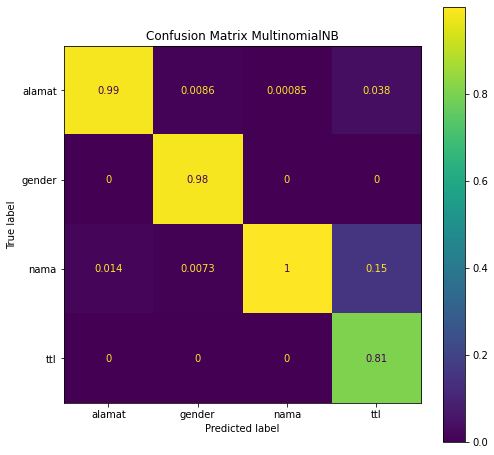

In [0]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib as plt

mnb_disp = plot_confusion_matrix(mnb, X_test_dtm, y_test,
                                 display_labels= encoder.classes_,
                                 cmap=plt.cm.viridis,normalize='pred')
mnb_disp.figure_.set_size_inches(8,8)
mnb_disp.ax_.set_title('Confusion Matrix MultinomialNB')

In [0]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_class = mnb.predict(X_test_dtm)
# print(f'accuracy => {accuracy_score(y_test, y_pred_class)}')

target_names = ['alamat','gender', 'nama','ttl']
print(classification_report(y_test, y_pred_class, target_names=target_names))

              precision    recall  f1-score   support

      alamat       0.99      0.95      0.97      1520
      gender       0.98      1.00      0.99      1486
        nama       1.00      0.79      0.88      1497
         ttl       0.81      1.00      0.89      1482

    accuracy                           0.93      5985
   macro avg       0.94      0.93      0.93      5985
weighted avg       0.94      0.93      0.93      5985



In [0]:
X_test[y_pred_class > y_test]

8557            menganti rawalo banyumas
1904                              ridani
1402                             subandi
4067                    jovitha andarini
1434                        aang sobirin
                      ...               
1589                        stevani nory
4210    rachel ravensca marisca loupatty
2483                     salman alfarisi
9211                           simokerto
4159                            matganti
Name: entity, Length: 367, dtype: object

In [0]:
X_test[y_pred_class < y_test]

2630                   hasanudin
1690               mayang savira
3441              indah dekawati
3258        indah lestariningsih
3087                  abdi karya
3203        yunita indah pramasa
4746                  ing dihana
234              i gede widiarta
3872              vina budiyanti
230           affan deska sayuti
335        opsidian izzuda buana
2037                peggy melati
797                  oki nuryana
2649                 mayang sari
609                    ulin nuha
938                 ulfa jayanti
670       sintong taripar sihite
2624          dessy pramita sari
586            rosky kumala sari
2323    jieliwosy silas salawati
2746             siprianus jumat
4494                 saka apreja
1722               oki lazzwardi
3195               indah lestari
3162                tamara digma
2170              rahmianti sari
4564             sindu mutusolah
4943      teddi kaharuddin saleh
111              hediati mustika
4144              musthofa kamal
2530      

In [0]:
#calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = mnb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.85540877e-02, 6.44234889e-13, 1.23512521e-06, ...,
       2.86127534e-14, 9.99999848e-01, 2.01293154e-02])

In [0]:
sorted_prob = mnb.feature_log_prob_[1, :].argsort()
feature_list = count_vect.get_feature_names()

for index in sorted_prob[-20:-1]:
  print(feature_list[index])

husein
husada
ht
hubertus
huda
hudaya
hudayana
hukama
husain
zulmi
hulu
humaedi
huntoro
huntulohulawa
hurip
hulo
wanita
perempuan
pria


## Hyperparameter Tuning

### Model Multinomial Naive Bayes

In [0]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

score = 'f1_micro'

In [0]:
mnb_cv = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring=score, n_jobs=-1)
mnb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [0]:
params = mnb_cv.cv_results_['params']
split_cv_0 = mnb_cv.cv_results_['split0_test_score']
split_cv_1 = mnb_cv.cv_results_['split1_test_score']
split_cv_2 = mnb_cv.cv_results_['split2_test_score']
split_cv_3 = mnb_cv.cv_results_['split3_test_score']
split_cv_4 = mnb_cv.cv_results_['split4_test_score']
mean_score = mnb_cv.cv_results_['mean_test_score']
rank = mnb_cv.cv_results_['rank_test_score']

clf__alpha = list()
tfidf__use_idf = list()
vect__ngram_range = list()

for i in range(len(params)):
  clf__alpha.append(params[i]['clf__alpha'])
  tfidf__use_idf.append(params[i]['tfidf__use_idf'])
  vect__ngram_range.append(params[i]['vect__ngram_range'])

mnb_result = pd.DataFrame({
              'rank': rank,
              'clf__alpha':clf__alpha,
              'tfidf__use_idf':tfidf__use_idf,
              'vect__ngram_range':vect__ngram_range,
              'split_cv_0': split_cv_0,
              'split_cv_1': split_cv_1,
              'split_cv_2': split_cv_2,
              'split_cv_3': split_cv_3,
              'split_cv_4': split_cv_4,
              'mean_score': mean_score })

mnb_result.sort_values(by=['rank'])

,rank,clf__alpha,tfidf__use_idf,vect__ngram_range,split_cv_0,split_cv_1,split_cv_2,split_cv_3,split_cv_4,mean_score
22,1,0.10000,False,"(1, 2)",0.924454,0.915145,0.925886,0.926960,0.920874,0.922664
21,2,0.10000,False,"(1, 1)",0.924096,0.914429,0.925170,0.925528,0.921232,0.922091
25,3,1.00000,True,"(1, 2)",0.923738,0.913713,0.924096,0.923738,0.920516,0.921160
28,3,1.00000,False,"(1, 2)",0.924096,0.914071,0.924454,0.922664,0.920516,0.921160
16,5,0.01000,False,"(1, 2)",0.923738,0.912281,0.924096,0.926244,0.919441,0.921160
27,6,1.00000,False,"(1, 1)",0.921590,0.914071,0.924096,0.923738,0.919799,0.920659
24,7,1.00000,True,"(1, 1)",0.922664,0.912639,0.924096,0.923738,0.919799,0.920587
15,7,0.01000,False,"(1, 1)",0.923380,0.911923,0.924096,0.924454,0.919083,0.920587
19,9,0.10000,True,"(1, 2)",0.923022,0.912281,0.923022,0.924812,0.919441,0.920516
10,10,0.00010,False,"(1, 2)",0.922664,0.911207,0.923380,0.925528,0.919441,0.920444


In [0]:
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, mnb_cv.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1520
           1       1.00      1.00      1.00      1486
           2       1.00      0.79      0.88      1497
           3       0.81      1.00      0.89      1482

    accuracy                           0.94      5985
   macro avg       0.95      0.94      0.94      5985
weighted avg       0.95      0.94      0.94      5985




In [0]:
print("Best Estimator: \n{}\n".format(mnb_cv.best_estimator_))
print("Best Parameters: \n{}\n".format(mnb_cv.best_params_))
print("Best Test Score: \n{}\n".format(mnb_cv.best_score_))

Best Estimator: 
Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

Best Parameters: 
{'clf__alpha'

In [0]:
mnb_cv_preds = mnb_cv.predict(pd.Series(np.array(predict_words)))
evaluation_test(mnb_cv_preds)

naufal ihsan pratama => nama
jl juraganan rt 01 no 25 => alamat
laki laki => gender
vivin febriyanti strk => nama


In [0]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_dtm,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
gbc_preds = gbc.predict(preds)
evaluation_test(gbc_preds)

naufal ihsan pratama => nama
jl juraganan rt 01 no 25 => alamat
laki laki => gender
vivin febriyanti strk => nama


In [0]:
print(f'Gradient Boost Score => {gbc.score(X_test_dtm, y_test)}')

Gradient Boost Score => 0.9590643274853801


### Model Gradient Boost Classifier

In [0]:
text_clf_2 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())])

tuned_parameters_2 = {
    'tfidf__use_idf': (True, False),
    'clf__n_estimators': [5, 50, 250],
    'clf__max_depth': [1, 3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 1, 10, 100]
}

score_2 = 'f1_micro'

In [0]:
gbc_cv = GridSearchCV(text_clf_2, tuned_parameters_2, cv=5, scoring=score_2, n_jobs=-1)
gbc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [0]:
gbc_cv_preds = gbc_cv.predict(pd.Series(np.array(predict_words)))
evaluation_test(gbc_cv_preds)

naufal ihsan pratama => nama
jl juraganan rt 01 no 25 => alamat
laki laki => gender
vivin febriyanti strk => nama


In [0]:
gbc_params = gbc_cv.cv_results_['params']
gbc_split_cv_0 = gbc_cv.cv_results_['split0_test_score']
gbc_split_cv_1 = gbc_cv.cv_results_['split1_test_score']
gbc_split_cv_2 = gbc_cv.cv_results_['split2_test_score']
gbc_split_cv_3 = gbc_cv.cv_results_['split3_test_score']
gbc_split_cv_4 = gbc_cv.cv_results_['split4_test_score']
gbc_mean_score = gbc_cv.cv_results_['mean_test_score']
gbc_rank = gbc_cv.cv_results_['rank_test_score']

clf__learning_rate = list()
clf__max_depth = list()
clf__n_estimators = list()
tfidf__use_idf = list()

for i in range(len(gbc_params)):
  clf__learning_rate.append(gbc_params[i]['clf__learning_rate'])
  clf__max_depth.append(gbc_params[i]['clf__max_depth'])
  clf__n_estimators.append(gbc_params[i]['clf__n_estimators'])
  tfidf__use_idf.append(gbc_params[i]['tfidf__use_idf'])

gbc_result = pd.DataFrame({
              'rank': gbc_rank,
              'clf__learning_rate':clf__learning_rate,
              'clf__max_depth':clf__max_depth,
              'clf__n_estimators':clf__n_estimators,
              'tfidf__use_idf':tfidf__use_idf,
              'split_cv_0': gbc_split_cv_0,
              'split_cv_1': gbc_split_cv_1,
              'split_cv_2': gbc_split_cv_2,
              'split_cv_3': gbc_split_cv_3,
              'split_cv_4': gbc_split_cv_4,
              'mean_score': gbc_mean_score })

gbc_result.sort_values(by=['rank'])

,rank,clf__learning_rate,clf__max_depth,clf__n_estimators,tfidf__use_idf,split_cv_0,split_cv_1,split_cv_2,split_cv_3,split_cv_4,mean_score
59,1,1.0,3,250,False,0.973863,0.968851,0.974221,0.973505,0.973505,0.972789
63,2,1.0,5,50,False,0.975653,0.968135,0.970999,0.973505,0.973505,0.972359
71,3,1.0,7,250,False,0.974579,0.968135,0.973147,0.970999,0.973505,0.972073
65,4,1.0,5,250,False,0.974221,0.968493,0.972431,0.972789,0.972073,0.972001
69,5,1.0,7,50,False,0.974937,0.968493,0.970999,0.971357,0.972789,0.971715
...,...,...,...,...,...,...,...,...,...,...,...
98,115,100.0,1,50,True,0.146796,0.153240,0.181525,0.145363,0.143215,0.154028
96,115,100.0,1,5,True,0.146796,0.153240,0.181525,0.145363,0.143215,0.154028
91,118,10.0,7,5,False,0.269961,0.136412,0.095596,0.105263,0.142499,0.149946
95,118,10.0,7,250,False,0.269961,0.136412,0.095596,0.105263,0.142499,0.149946


In [0]:
print("Detailed classification report:")
print()
print("The model is trained on the full train set.")
print("The scores are computed on the full test set.")
print()
y_true, y_pred = y_test, gbc_cv.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.99      0.90      0.95      1520
           1       1.00      1.00      1.00      1486
           2       0.91      1.00      0.95      1497
           3       1.00      1.00      1.00      1482

    accuracy                           0.97      5985
   macro avg       0.98      0.97      0.97      5985
weighted avg       0.98      0.97      0.97      5985




### Model LSTM

In [0]:
X = df1.entity
y = pd.get_dummies(df1.category).values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

In [0]:
vocab_size = 5000
max_seq_word = 12
embedding_size = 64

In [0]:
X_lstm_train, X_lstm_val, y_lstm_train, y_lstm_val = train_test_split(X_train, y_train, train_size = 0.9, random_state = 21)

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, filters = punctuation, lower= True)
tokenizer.fit_on_texts(X_lstm_train.values)

In [42]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8657 unique tokens.


In [43]:
dict(list(word_index.items())[0:5])

{'laki': 1, 'no': 4, 'pria': 2, 'rt': 3, 'rw': 5}

In [0]:
lstm_train_seq = tokenizer.texts_to_sequences(X_lstm_train.values)
lstm_val_seq = tokenizer.texts_to_sequences(X_lstm_val.values)

In [0]:
lstm_train_padded = sequence.pad_sequences(lstm_train_seq, maxlen= max_seq_word)
lstm_val_padded = sequence.pad_sequences(lstm_val_seq, maxlen= max_seq_word)

In [46]:
lstm_train_seq[0]

[185, 2632]

In [47]:
lstm_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  185,
       2632], dtype=int32)

In [50]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_entity(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_entity(lstm_train_padded[2]))
print('==== DECODE ====')
print(X_lstm_train.values[2])

? ? ? ? ? ? ? ? jakarta 12 05 1988
==== DECODE ====
jakarta 12 05 1988


In [55]:
def tuning_lstm(x_train, y_train, x_val, y_val, params):
    
    dropout = float(params['dropout'])
    lstm_neuron = int(params['lstm_neuron'])
    
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size))
    model.add(SpatialDropout1D(dropout))
    model.add(
          LSTM (
            lstm_neuron,
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            dropout=dropout
      )
    )
    model.add(Dense(4, activation='softmax'))
    
    model.compile(
        optimizer=params['optimizer'],
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    out = model.fit(
        x_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
        verbose=1,
        validation_data=[x_val, y_val]
    )
    
    return out, model

tuned_parameters_3 = {
    'epochs': [5],
    'batch_size': [32, 64],
    'lstm_neuron': [100, 200],
    'optimizer': ['adam'],
    'dropout': [0.2,0.3,0.4]
}

scan_results = talos.Scan(lstm_train_padded, y_lstm_train,
                          x_val=lstm_val_padded, y_val=y_lstm_val,
                          params=tuned_parameters_3,
                          model=tuning_lstm,
                          experiment_name='Tuning LSTM Model')


  0%|          | 0/12 [00:00<?, ?it/s]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 9s 691us/step - loss: 0.3132 - accuracy: 0.8869 - val_loss: 0.0746 - val_accuracy: 0.9764
Epoch 2/5
12568/12568 [==============================] - 8s 647us/step - loss: 0.0421 - accuracy: 0.9862 - val_loss: 0.0563 - val_accuracy: 0.9814
Epoch 3/5
12568/12568 [==============================] - 8s 649us/step - loss: 0.0189 - accuracy: 0.9951 - val_loss: 0.0453 - val_accuracy: 0.9828
Epoch 4/5
12568/12568 [==============================] - 8s 646us/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0490 - val_accuracy: 0.9835
Epoch 5/5
12568/12568 [==============================] - 8s 645us/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.0446 - val_accuracy: 0.9835



  8%|▊         | 1/12 [00:42<07:51, 42.89s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.2766 - accuracy: 0.9093 - val_loss: 0.0679 - val_accuracy: 0.9757
Epoch 2/5
12568/12568 [==============================] - 19s 1ms/step - loss: 0.0420 - accuracy: 0.9855 - val_loss: 0.0475 - val_accuracy: 0.9814
Epoch 3/5
12568/12568 [==============================] - 18s 1ms/step - loss: 0.0175 - accuracy: 0.9955 - val_loss: 0.0552 - val_accuracy: 0.9828
Epoch 4/5
12568/12568 [==============================] - 18s 1ms/step - loss: 0.0140 - accuracy: 0.9966 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 5/5
12568/12568 [==============================] - 18s 1ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0524 - val_accuracy: 0.9835



 17%|█▋        | 2/12 [02:17<09:42, 58.28s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 9s 685us/step - loss: 0.3406 - accuracy: 0.8770 - val_loss: 0.0697 - val_accuracy: 0.9749
Epoch 2/5
12568/12568 [==============================] - 8s 656us/step - loss: 0.0495 - accuracy: 0.9835 - val_loss: 0.0511 - val_accuracy: 0.9807
Epoch 3/5
12568/12568 [==============================] - 8s 652us/step - loss: 0.0219 - accuracy: 0.9936 - val_loss: 0.0529 - val_accuracy: 0.9800
Epoch 4/5
12568/12568 [==============================] - 8s 646us/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0469 - val_accuracy: 0.9807
Epoch 5/5
12568/12568 [==============================] - 8s 652us/step - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.0419 - val_accuracy: 0.9850



 25%|██▌       | 3/12 [03:00<08:03, 53.68s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.3131 - accuracy: 0.8935 - val_loss: 0.0747 - val_accuracy: 0.9742
Epoch 2/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.0565 - val_accuracy: 0.9807
Epoch 3/5
12568/12568 [==============================] - 19s 1ms/step - loss: 0.0237 - accuracy: 0.9936 - val_loss: 0.0572 - val_accuracy: 0.9843
Epoch 4/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.0445 - val_accuracy: 0.9843
Epoch 5/5
12568/12568 [==============================] - 19s 1ms/step - loss: 0.0136 - accuracy: 0.9967 - val_loss: 0.0565 - val_accuracy: 0.9828



 33%|███▎      | 4/12 [04:36<08:51, 66.47s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 9s 699us/step - loss: 0.3419 - accuracy: 0.8797 - val_loss: 0.0671 - val_accuracy: 0.9778
Epoch 2/5
12568/12568 [==============================] - 8s 659us/step - loss: 0.0608 - accuracy: 0.9794 - val_loss: 0.0614 - val_accuracy: 0.9800
Epoch 3/5
12568/12568 [==============================] - 8s 664us/step - loss: 0.0298 - accuracy: 0.9902 - val_loss: 0.0429 - val_accuracy: 0.9828
Epoch 4/5
12568/12568 [==============================] - 8s 658us/step - loss: 0.0202 - accuracy: 0.9946 - val_loss: 0.0439 - val_accuracy: 0.9835
Epoch 5/5
12568/12568 [==============================] - 8s 657us/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.0429 - val_accuracy: 0.9850



 42%|████▏     | 5/12 [05:19<06:57, 59.60s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.3362 - accuracy: 0.8784 - val_loss: 0.0747 - val_accuracy: 0.9742
Epoch 2/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.0585 - accuracy: 0.9800 - val_loss: 0.0482 - val_accuracy: 0.9814
Epoch 3/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0497 - val_accuracy: 0.9828
Epoch 4/5
12568/12568 [==============================] - 19s 2ms/step - loss: 0.0221 - accuracy: 0.9942 - val_loss: 0.0411 - val_accuracy: 0.9843
Epoch 5/5
12568/12568 [==============================] - 19s 1ms/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.0492 - val_accuracy: 0.9843



 50%|█████     | 6/12 [06:56<07:04, 70.77s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 8s 616us/step - loss: 0.4624 - accuracy: 0.8468 - val_loss: 0.1118 - val_accuracy: 0.9642
Epoch 2/5
12568/12568 [==============================] - 7s 567us/step - loss: 0.0635 - accuracy: 0.9786 - val_loss: 0.0538 - val_accuracy: 0.9814
Epoch 3/5
12568/12568 [==============================] - 7s 569us/step - loss: 0.0302 - accuracy: 0.9901 - val_loss: 0.0458 - val_accuracy: 0.9828
Epoch 4/5
12568/12568 [==============================] - 7s 567us/step - loss: 0.0180 - accuracy: 0.9959 - val_loss: 0.0452 - val_accuracy: 0.9821
Epoch 5/5
12568/12568 [==============================] - 7s 567us/step - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0432 - val_accuracy: 0.9828



 58%|█████▊    | 7/12 [07:34<05:04, 60.91s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.4444 - accuracy: 0.8405 - val_loss: 0.0883 - val_accuracy: 0.9671
Epoch 2/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.0642 - accuracy: 0.9791 - val_loss: 0.0515 - val_accuracy: 0.9800
Epoch 3/5
12568/12568 [==============================] - 12s 989us/step - loss: 0.0279 - accuracy: 0.9908 - val_loss: 0.0447 - val_accuracy: 0.9835
Epoch 4/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.0175 - accuracy: 0.9952 - val_loss: 0.0615 - val_accuracy: 0.9821
Epoch 5/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.0432 - val_accuracy: 0.9828



 67%|██████▋   | 8/12 [08:39<04:08, 62.19s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 8s 607us/step - loss: 0.4878 - accuracy: 0.8425 - val_loss: 0.0908 - val_accuracy: 0.9692
Epoch 2/5
12568/12568 [==============================] - 7s 565us/step - loss: 0.0720 - accuracy: 0.9759 - val_loss: 0.0811 - val_accuracy: 0.9821
Epoch 3/5
12568/12568 [==============================] - 7s 566us/step - loss: 0.0360 - accuracy: 0.9892 - val_loss: 0.0644 - val_accuracy: 0.9792
Epoch 4/5
12568/12568 [==============================] - 7s 563us/step - loss: 0.0212 - accuracy: 0.9940 - val_loss: 0.0461 - val_accuracy: 0.9828
Epoch 5/5
12568/12568 [==============================] - 7s 562us/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0432 - val_accuracy: 0.9828



 75%|███████▌  | 9/12 [09:17<02:44, 54.81s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.4467 - accuracy: 0.8530 - val_loss: 0.0885 - val_accuracy: 0.9721
Epoch 2/5
12568/12568 [==============================] - 13s 996us/step - loss: 0.0678 - accuracy: 0.9780 - val_loss: 0.0650 - val_accuracy: 0.9778
Epoch 3/5
12568/12568 [==============================] - 13s 996us/step - loss: 0.0310 - accuracy: 0.9904 - val_loss: 0.0519 - val_accuracy: 0.9807
Epoch 4/5
12568/12568 [==============================] - 13s 999us/step - loss: 0.0191 - accuracy: 0.9950 - val_loss: 0.0467 - val_accuracy: 0.9835
Epoch 5/5
12568/12568 [==============================] - 13s 999us/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0446 - val_accuracy: 0.9835



 83%|████████▎ | 10/12 [10:22<01:55, 57.85s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 8s 612us/step - loss: 0.5186 - accuracy: 0.8202 - val_loss: 0.1036 - val_accuracy: 0.9649
Epoch 2/5
12568/12568 [==============================] - 7s 564us/step - loss: 0.0864 - accuracy: 0.9730 - val_loss: 0.0632 - val_accuracy: 0.9778
Epoch 3/5
12568/12568 [==============================] - 7s 561us/step - loss: 0.0488 - accuracy: 0.9838 - val_loss: 0.0554 - val_accuracy: 0.9814
Epoch 4/5
12568/12568 [==============================] - 7s 560us/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 0.0476 - val_accuracy: 0.9828
Epoch 5/5
12568/12568 [==============================] - 7s 563us/step - loss: 0.0191 - accuracy: 0.9954 - val_loss: 0.0456 - val_accuracy: 0.9835



 92%|█████████▏| 11/12 [10:59<00:51, 51.76s/it]

Train on 12568 samples, validate on 1397 samples
Epoch 1/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.4686 - accuracy: 0.8365 - val_loss: 0.1672 - val_accuracy: 0.9420
Epoch 2/5
12568/12568 [==============================] - 13s 1ms/step - loss: 0.0838 - accuracy: 0.9710 - val_loss: 0.0558 - val_accuracy: 0.9800
Epoch 3/5
12568/12568 [==============================] - 13s 998us/step - loss: 0.0405 - accuracy: 0.9868 - val_loss: 0.0497 - val_accuracy: 0.9835
Epoch 4/5
12568/12568 [==============================] - 12s 989us/step - loss: 0.0245 - accuracy: 0.9932 - val_loss: 0.0556 - val_accuracy: 0.9814
Epoch 5/5
12568/12568 [==============================] - 13s 997us/step - loss: 0.0183 - accuracy: 0.9952 - val_loss: 0.0502 - val_accuracy: 0.9828



100%|██████████| 12/12 [12:04<00:00, 60.39s/it]


In [56]:
scan_results.details

experiment_name        Tuning LSTM Model
random_method           uniform_mersenne
reduction_method                    None
reduction_interval                    50
reduction_window                      20
reduction_threshold                  0.2
reduction_metric                 val_acc
complete_time             06/12/20/02:46
x_shape                      (12568, 12)
y_shape                       (12568, 4)
dtype: object

In [57]:
analyze_object = talos.Analyze(scan_results)
analyze_object.data.sort_values(by=['val_accuracy'],ascending=False)

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,lstm_neuron,optimizer
2,5,0.041901,0.984968,0.013343,0.996499,32,0.3,5,100,adam
4,5,0.042933,0.984968,0.015675,0.996022,32,0.4,5,100,adam
5,5,0.049201,0.984252,0.014432,0.996260,32,0.4,5,200,adam
0,5,0.044605,0.983536,0.013079,0.996738,32,0.2,5,100,adam
1,5,0.052357,0.983536,0.011748,0.996897,32,0.2,5,200,adam
9,5,0.044575,0.983536,0.014818,0.996738,64,0.3,5,200,adam
10,5,0.045627,0.983536,0.019056,0.995385,64,0.4,5,100,adam
3,5,0.056500,0.982820,0.013616,0.996738,32,0.3,5,200,adam
6,5,0.043207,0.982820,0.013871,0.996658,64,0.2,5,100,adam
7,5,0.043184,0.982820,0.014257,0.996738,64,0.2,5,200,adam


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


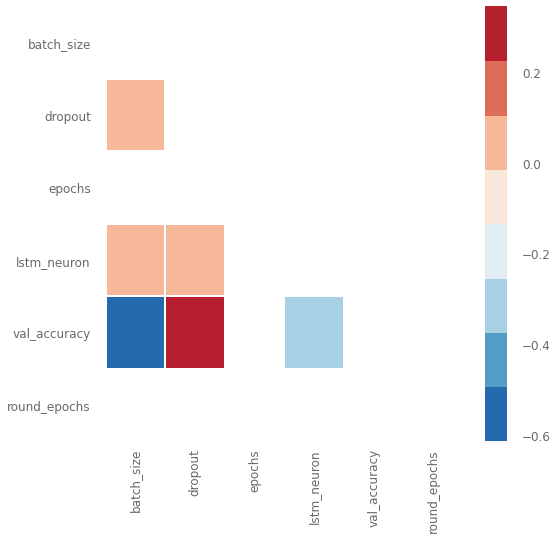

In [58]:
analyze_object.plot_corr('val_accuracy', ['accuracy', 'loss', 'val_loss'])

In [60]:
talos.Deploy(scan_object=scan_results, model_name='lstm_deploy_3', metric='val_accuracy')

Deploy package lstm_deploy_3 have been saved.


In [61]:
!ls -al

total 1956
drwxr-xr-x 1 root root    4096 Jun 12 03:00  .
drwxr-xr-x 1 root root    4096 Jun 12 02:14  ..
drwxr-xr-x 1 root root    4096 Jun 10 16:28  .config
-rw-r--r-- 1 root root  537182 Jun 12 02:24  dw_customer_5000.csv
-rw-r--r-- 1 root root 1438433 Jun 12 03:00  lstm_deploy_3.zip
drwxr-xr-x 1 root root    4096 Jun 10 16:28  sample_data
drwxr-xr-x 2 root root    4096 Jun 12 02:34 'Tuning LSTM Model'


In [0]:
lstm_model = talos.Restore('lstm_deploy_3.zip')

In [64]:
lstm_model.params

{'batch_size': [32, 64],
 'dropout': [0.2, 0.3, 0.4],
 'epochs': [5],
 'lstm_neuron': [100, 200],
 'optimizer': ['adam']}

In [65]:
predict_wordss = ['naufal ihsan pratama',
                  'jl juraganan rt 01 no 25',
                  'wanita',
                  'bahy helmi',
                  'vivin febriyanti',
                  'pejaten timur pasar minggu']

tokens = tokenizer.texts_to_sequences(predict_wordss)
pad_seq = sequence.pad_sequences(tokens, maxlen=max_seq_word)
result = lstm_model.model.predict(pad_seq)

labels = ['alamat','gender','nama','ttl']

for r in range(len(result)):
  print(predict_wordss[r], labels[np.argmax(result[r])])

naufal ihsan pratama nama
jl juraganan rt 01 no 25 alamat
wanita gender
bahy helmi nama
vivin febriyanti nama
pejaten timur pasar minggu alamat


In [0]:
tokens = tokenizer.texts_to_sequences(X_test)
pad_seq = sequence.pad_sequences(tokens, maxlen=max_seq_word)
result = lstm_model.model.predict(pad_seq)

labels = ['alamat','gender','nama','ttl']

for r in range(len(result)):
  print(X_test.values[r], labels[np.argmax(result[r])])

### Compare Between Models

In [0]:
encoder = load('encoder.joblib')
tokenizer = load('tokenizer.joblib')
gbc_cv = load('gbc_cv.joblib')
mnb_cv = load('mnb_cv.joblib')

In [0]:
mnb_scores = cross_val_score(mnb_cv, X_test, y_test, cv=3, n_jobs=-1)

In [52]:
mnb_scores

array([0.90225564, 0.91278195, 0.90877193])

In [0]:
gbc_scores = cross_val_score(gbc_cv, X_test, y_test, cv=3, n_jobs=-1)

In [54]:
gbc_scores

array([0.96240602, 0.97393484, 0.96390977])

In [0]:
lstm_cv = talos.Restore('lstm_deploy_3.zip')

In [0]:
lstm_test_seq = tokenizer.texts_to_sequences(X_test.values)

In [0]:
lstm_test_padded = sequence.pad_sequences(lstm_test_seq, maxlen=12)

In [0]:
y_lstm_test = pd.get_dummies(y_test)

In [59]:
evaluate_object = talos.Evaluate(scan_results)
evaluate_object.evaluate(lstm_test_padded, y_lstm_test, folds=10, metric='val_accuracy', task='multi_label')

[0.999221641984365,
 0.9967999918079791,
 0.9951923076923077,
 0.9984248804397436,
 0.9968228031953522,
 0.9975631107010197,
 0.9944176356416603,
 0.9975859262990661,
 0.9969146350725298,
 0.9966681450271648]